[[  5.75798464]
 [ 10.18186493]
 [ -7.69125177]
 [-10.34759031]
 [ -1.83065704]]


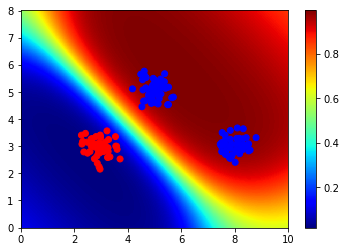

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import math


def fi_x_NM (x,u_m,S):                 #通过u_m控制w的个数（增加到多少维度M）
    N=len(x)
    M=len(u_m)
    fi_x=np.zeros([N,M])
    for n in range(0,N):
        for m in range(0,M):
            fi_x[n][m]=math.exp(-((x[n][0]-u_m[m])*(x[n][0]-u_m[m])+(x[n][1]-u_m[m])*(x[n][1]-u_m[m]))/(2*S*S))
    return fi_x       #得到fi_x，为N*M

def sigmoid (a):                               #a为sigma函数的输入
    sigmoid_a=1/(1+math.exp(-a))
    return sigmoid_a

def sigmoid_ba_N1 (w,fi_x):          
    N=len(fi_x)                  #N为150
    sigmoid_ba=np.zeros([N,1])
    for n in range (0,N):
        a=np.dot(w.T,fi_x[n].T)        #w.T为1*M，fi（xn）为M*1，求出一个xn（二维的）对sigma函数的输入wT*fi（xn）
        sigmoid_ba[n]=sigmoid(a)            #a为sigma函数的输入
    return sigmoid_ba                       


def D_E_M1 (w,a,fi_x,sigmoid_ba,t_ba):    #a为p(w)的方差阿尔法
    M = len(w)
    II = np.eye(M)
    SS0=(1/a)*II 
    SS0_inv=linalg.inv(SS0)
    m0=np.zeros([M,1])
    tmp1=np.dot(SS0_inv,(w-m0))
    tmp2=np.dot(fi_x.T,(sigmoid_ba.T-t_ba).T)    #有问题！！！！tba没转置
    D_E=tmp1+tmp2
    return D_E

def get_H (simoid_ba,fi_x,w,a):
    M = len(w)
    N=len(sigmoid_ba)
    II = np.eye(M)
    III=np.eye(N)
    SS0=(1/a)*II 
    SS0_inv=linalg.inv(SS0)
    Rnn=sigmoid_ba*(1-sigmoid_ba)
    R=III*Rnn
    tmp1=np.dot(fi_x.T,R)
    tmp=np.dot(tmp1,fi_x)
    H=SS0_inv+tmp
    return H

def sigmoid_test (x,w,um,S):
    fi_x=np.zeros([M,1])
    N=len(fi_x)
    for n in range (0,N):
        fi_x[n]=math.exp(-((x[0]-um[n])*(x[0]-um[n])+(x[1]-um[n])*(x[1]-um[n]))/(2*S*S))
    #print(fi_x)
    a=np.dot(w.T,fi_x)  
    #print(a)
    result=sigmoid(a)
    a_map=a
    return result,a_map,fi_x
    

N1=50
N2=50
N3=50
K=2
sigma=0.1

mean=(3,3)
cov=[[sigma,0],[0,sigma]]
X1=np.random.multivariate_normal(mean,cov,N1)
c1=['red']*len(X1)


mean=(5,5)
cov=[[sigma,0],[0,sigma]]
X2=np.random.multivariate_normal(mean,cov,N2)
c2=['blue']*len(X2)


mean=(8,3)
cov=[[sigma,0],[0,sigma]]
X3=np.random.multivariate_normal(mean,cov,N3)
c3=['blue']*len(X3)


X=np.concatenate((X1,X2,X3))
color=np.concatenate((c1,c2,c3))




T=0*np.ones([len(X),K])
for n in range(0,len(X)):
    if(n<len(X1)):
        T[n][0]=1
    if(n>=N1 and n<len(X1)+len(X2)+len(X3)):
        T[n][1]=1
        
T=T.astype(int)
T=T.T
M=5
S=3
um=np.linspace(0,10,M)
w0=np.zeros([M,1])

fi_x=fi_x_NM(X,um,S)    #check
sigmoid_ba=sigmoid_ba_N1(w0,fi_x)     #check


a=0.01
t_ba=T[0]
D_E = D_E_M1 (w0,a,fi_x,sigmoid_ba,t_ba)   

H=get_H(sigmoid_ba,fi_x,w0,a)
H_inv=linalg.inv(H)

w=w0
iteration_time=0
w_new=w+1
w_old=w
for n in range (0,20):
    sigmoid_ba=sigmoid_ba_N1(w,fi_x)
    D_E = D_E_M1 (w,a,fi_x,sigmoid_ba,t_ba)  
    H=get_H(sigmoid_ba,fi_x,w,a)
    H_inv=linalg.inv(H)
    tmp=np.dot(H_inv,D_E)
    w=w-np.dot(H_inv,D_E)
#print(H_inv)
#print(iteration_time)
#print(w)

xx=np.linspace(0,10,50)
yy=np.linspace(0,8,50)

x_new=[0,0]
[result,a_map,fi_x_1]=sigmoid_test (x_new,w,um,S)
#print(result)
tmp=np.dot(fi_x_1.T,H_inv)
sigma_new=np.dot(tmp,fi_x_1)
inp=a_map/math.sqrt(1+sigma_new*math.pi/8)
p_tnew_tba=sigmoid (inp)

plt.scatter(X[:,0],X[:,1],marker='o',c=color)

color_num=500
x_color=np.linspace(0,10,color_num)
y_color=np.linspace(0,8,color_num)

z = np.zeros((color_num,color_num))
for i,a in enumerate(x_color):
    for j,b in enumerate(y_color):  
        x_new=[a,b]
        [result,a_map,fi_x_1]=sigmoid_test (x_new,w,um,S)
        #print(result)
        tmp=np.dot(fi_x_1.T,H_inv)
        sigma_new=np.dot(tmp,fi_x_1)
        inp=a_map/math.sqrt(1+sigma_new*math.pi/8)
        p_tnew_tba=sigmoid (inp)
        #print(p_tnew_tba)
        z[i,j] = 1-p_tnew_tba

    
#构造点
Xn,Yn=np.meshgrid(x_color,y_color)
cm=plt.cm.get_cmap('jet')
plt.pcolormesh(Xn,Yn,z.T,cmap=cm)
plt.colorbar()

plt.scatter(X[:,0],X[:,1],marker='o',c=color)

In [6]:
x_in=float(input('Input the x axis:'))
y_in=float(input('Input the y axis:'))
x_new=[x_in,y_in]
print('Input point is:',x_new)
[result,a_map,fi_x_1]=sigmoid_test (x_new,w,um,S)
tmp=np.dot(fi_x_1.T,H_inv)
sigma_new=np.dot(tmp,fi_x_1)
inp=a_map/math.sqrt(1+sigma_new*math.pi/8)
p_tnew_tba=sigmoid (inp)
if p_tnew_tba>0.5:
    print('The point is in the class A(Red)')
else:
    print('The point is in the class B(Blue)')

Input the x axis:5
Input the y axis:5
Input point is: [5.0, 5.0]
The point is in the class B(Blue)
